In [1]:
import os, sys
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import joblib  # To save & load the pipeline
%matplotlib inline

In [2]:
PROJECT_ROOT = '/home/ar-in-u-301/Documents/MakeMyTripAssignment'
DATA_FOLDER = os.path.join(PROJECT_ROOT,'data')
TRAIN_PATH = os.path.join(DATA_FOLDER, 'train.feather')
PIPELINE_ASSETS = os.path.join( PROJECT_ROOT, 'pipeline_assets')

In [3]:
#Read Data
searches = pd.read_feather(TRAIN_PATH)

In [4]:
searches.shape

(3177094, 25)

In [5]:
searches.columns

Index(['FROM_TO_CITY', 'LAT_FROM_CITY', 'LON_FROM_CITY', 'AREA_FROM_CITY',
       'LAT_TO_CITY', 'LON_TO_CITY', 'AREA_TO_CITY', 'DAYS_AFTER_01JAN2023',
       'TRAVEL_DAY_OF_WEEK', 'TRAVEL_DAY_OF_MONTH', 'TRAVEL_DAY_OF_YEAR',
       'SEARCH_TIMESTAMP_AFTER_01JAN2023', 'OTHER1', 'OTHER2', 'OTHER3',
       'OTHER4', 'PRICE1', 'PRICE2', 'PRICE3', 'PRICE4', 'PRICE5', 'PRICE6',
       'PRICE7', 'PRICE8', 'ACTIVITY_TYPE'],
      dtype='object')

In [6]:
# Let's separate out features and target
X, Y = searches.drop(['ACTIVITY_TYPE'], axis=1), searches['ACTIVITY_TYPE']

In [7]:
# Get Train and Validation Splits
train, val, y_train, y_val = train_test_split(X, Y, test_size=0.1, random_state=100, shuffle=True, stratify=Y)

In [8]:
train.shape, val.shape

((2859384, 24), (317710, 24))

In [9]:
train.head()

,FROM_TO_CITY,LAT_FROM_CITY,LON_FROM_CITY,AREA_FROM_CITY,LAT_TO_CITY,LON_TO_CITY,AREA_TO_CITY,DAYS_AFTER_01JAN2023,TRAVEL_DAY_OF_WEEK,TRAVEL_DAY_OF_MONTH,...,OTHER3,OTHER4,PRICE1,PRICE2,PRICE3,PRICE4,PRICE5,PRICE6,PRICE7,PRICE8
1080368,32,77.085327,28.646486,1.505246,72.832405,21.165391,0.545107,1.0,1.0,2.0,...,0.0,0.0,13091.0,9399.0,9419.0,21012.0,10679.0,-1.0,5417.0,10695.0
1460718,19,74.642658,33.896614,1.138534,77.085327,28.646486,1.505246,-115.0,4.0,8.0,...,0.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2647583,46,76.421700,10.052115,1.510669,77.085327,28.646486,1.505246,-309.0,6.0,26.0,...,0.0,0.0,-1.0,8621.0,8512.0,8621.0,8512.0,8512.0,14146.0,8512.0
2254046,692,80.031475,12.924160,1.945181,95.030167,27.405685,3.405019,-355.0,2.0,11.0,...,0.0,0.0,-1.0,-1.0,10087.0,16818.0,17268.0,13368.0,-1.0,-1.0
2772768,797,74.010479,15.347936,3.730879,95.030167,27.405685,3.405019,-259.0,7.0,17.0,...,0.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2859384 entries, 1080368 to 2781157
Data columns (total 24 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   FROM_TO_CITY                      int64  
 1   LAT_FROM_CITY                     float64
 2   LON_FROM_CITY                     float64
 3   AREA_FROM_CITY                    float64
 4   LAT_TO_CITY                       float64
 5   LON_TO_CITY                       float64
 6   AREA_TO_CITY                      float64
 7   DAYS_AFTER_01JAN2023              float64
 8   TRAVEL_DAY_OF_WEEK                float64
 9   TRAVEL_DAY_OF_MONTH               float64
 10  TRAVEL_DAY_OF_YEAR                float64
 11  SEARCH_TIMESTAMP_AFTER_01JAN2023  float64
 12  OTHER1                            float64
 13  OTHER2                            float64
 14  OTHER3                            float64
 15  OTHER4                            float64
 16  PRICE1                            f

In [11]:
# We have 3 columns that are currently encoded as numerical features -  TRAVEL_DAY_OF_WEEK, TRAVEL_DAY_OF_MONTH , TRAVEL_DAY_OF_YEAR
# It would be better to transform them so that the cyclicity can be captured
# Using Sin, Cos transformations for this would be better

def add_sin_cos(col, max_value, df):

    #Create sine
    df[col+"_sin"] = np.sin(2 * np.pi * df[col] / max_value)
    df[col + "_cos"] = np.cos(2 * np.pi * df[col] / max_value)

    # Drop original column
    df.drop([col], axis=1, inplace=True)

    return df

In [12]:
train['TRAVEL_DAY_OF_WEEK'].max()

np.float64(7.0)

In [13]:
MAX_WEEK_VAL = 7.0
train = add_sin_cos('TRAVEL_DAY_OF_WEEK', MAX_WEEK_VAL, train)
val = add_sin_cos('TRAVEL_DAY_OF_WEEK', MAX_WEEK_VAL, val)

In [14]:
train['TRAVEL_DAY_OF_MONTH'].max()

np.float64(31.0)

In [15]:
MAX_MONTH_VAL = 31.0
train = add_sin_cos('TRAVEL_DAY_OF_MONTH', MAX_MONTH_VAL, train)
val = add_sin_cos('TRAVEL_DAY_OF_MONTH', MAX_MONTH_VAL, val)

In [16]:
train['TRAVEL_DAY_OF_YEAR'].max()

np.float64(365.0)

In [17]:
MAX_YEAR_VAL = 365.0
train = add_sin_cos('TRAVEL_DAY_OF_YEAR', MAX_YEAR_VAL, train)
val = add_sin_cos('TRAVEL_DAY_OF_YEAR', MAX_YEAR_VAL, val)

In [18]:
train.describe()

,FROM_TO_CITY,LAT_FROM_CITY,LON_FROM_CITY,AREA_FROM_CITY,LAT_TO_CITY,LON_TO_CITY,AREA_TO_CITY,DAYS_AFTER_01JAN2023,SEARCH_TIMESTAMP_AFTER_01JAN2023,OTHER1,...,PRICE5,PRICE6,PRICE7,PRICE8,TRAVEL_DAY_OF_WEEK_sin,TRAVEL_DAY_OF_WEEK_cos,TRAVEL_DAY_OF_MONTH_sin,TRAVEL_DAY_OF_MONTH_cos,TRAVEL_DAY_OF_YEAR_sin,TRAVEL_DAY_OF_YEAR_cos
count,2.859384e+06,2.859384e+06,2.859384e+06,2.859384e+06,2.859384e+06,2.859384e+06,2.859384e+06,2.859384e+06,2.859384e+06,2.859384e+06,...,2.859384e+06,2.859384e+06,2.859384e+06,2.859384e+06,2.859384e+06,2.859384e+06,2.859384e+06,2.859384e+06,2.859384e+06,2.859384e+06
mean,5.156551e+02,7.838041e+01,2.109743e+01,1.820971e+00,7.841872e+01,2.107691e+01,1.814290e+00,-9.504103e+01,-1.131151e+02,1.464983e+00,...,5.086875e+03,4.816405e+03,4.562804e+03,4.099596e+03,-2.800648e-02,4.460937e-02,9.201331e-03,-3.207122e-02,1.635105e-01,1.394125e-01
std,6.403081e+02,5.180643e+00,6.398847e+00,2.026694e+00,5.257203e+00,6.415002e+00,2.012994e+00,1.368677e+02,1.346084e+02,9.615900e-01,...,5.100050e+03,5.207978e+03,5.086103e+03,4.934921e+03,7.028658e-01,7.093699e-01,7.119052e-01,7.014828e-01,7.124059e-01,6.680619e-01
min,0.000000e+00,6.963878e+01,8.541226e+00,3.491201e-02,6.963878e+01,8.541226e+00,3.491201e-02,-3.640000e+02,-3.638546e+02,0.000000e+00,...,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-9.749279e-01,-9.009689e-01,-9.987165e-01,-9.948693e-01,-9.999907e-01,-9.999630e-01
25%,9.900000e+01,7.464266e+01,1.534794e+01,1.129590e+00,7.464266e+01,1.534794e+01,1.129590e+00,-2.150000e+02,-2.314733e+02,1.000000e+00,...,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-7.818315e-01,-9.009689e-01,-7.247928e-01,-7.587581e-01,-5.452404e-01,-4.597327e-01
50%,2.870000e+02,7.708533e+01,2.094008e+01,1.505246e+00,7.708533e+01,2.024189e+01,1.505246e+00,-7.600000e+01,-9.496976e+01,1.000000e+00,...,5.138000e+03,4.702000e+03,4.360000e+03,3.319500e+03,-2.449294e-16,-2.225209e-01,-2.449294e-16,-5.064917e-02,3.294085e-01,2.595118e-01
75%,7.120000e+02,8.003148e+01,2.683035e+01,2.137613e+00,8.003148e+01,2.683035e+01,2.137613e+00,1.600000e+01,4.958796e-01,2.000000e+00,...,7.939000e+03,7.644000e+03,7.423000e+03,7.129000e+03,7.818315e-01,6.234898e-01,7.247928e-01,6.889669e-01,8.631421e-01,7.721566e-01
max,4.691000e+03,9.622460e+01,3.389661e+01,2.506288e+01,9.622460e+01,3.389661e+01,2.506288e+01,4.660000e+02,1.087705e+02,9.000000e+00,...,1.164240e+05,1.507610e+05,1.214740e+05,1.358150e+05,9.749279e-01,1.000000e+00,9.987165e-01,1.000000e+00,9.999907e-01,1.000000e+00


In [19]:
# No Missing Values
for col in train.columns:
    if train[col].isnull().sum() > 0:
        print(col)

In [20]:
# The first column is the CITY PAIR ENCODING, which is currently encoded as number, but actually a categorical
city_pair_train = train['FROM_TO_CITY']
city_pair_val = val['FROM_TO_CITY']

#Drop these columns
train.drop(['FROM_TO_CITY'], axis=1, inplace=True)
val.drop(['FROM_TO_CITY'], axis=1, inplace=True)

In [21]:
# Helper Function to check importance of numerical variable
# perform t-test
def perform_t_test(col, df, y):
    group0 = df[y == 0][col].dropna()
    group1 = df[y == 1][col].dropna()
    t_stat, p_value = ttest_ind(group0, group1)

    return p_value < 0.05

In [22]:
# Check which columns are actually relevant for predicting ACTIVITY_TYPE
useful_columns = []
for col in train.columns:
    if col != 'ACTIVITY_TYPE':
        if perform_t_test(col, train, y_train):
            useful_columns.append(col)

In [23]:
len( useful_columns )

25

In [24]:
#Let's subset train and valid data to keep only these columns
train = train[useful_columns]
val = val[useful_columns]

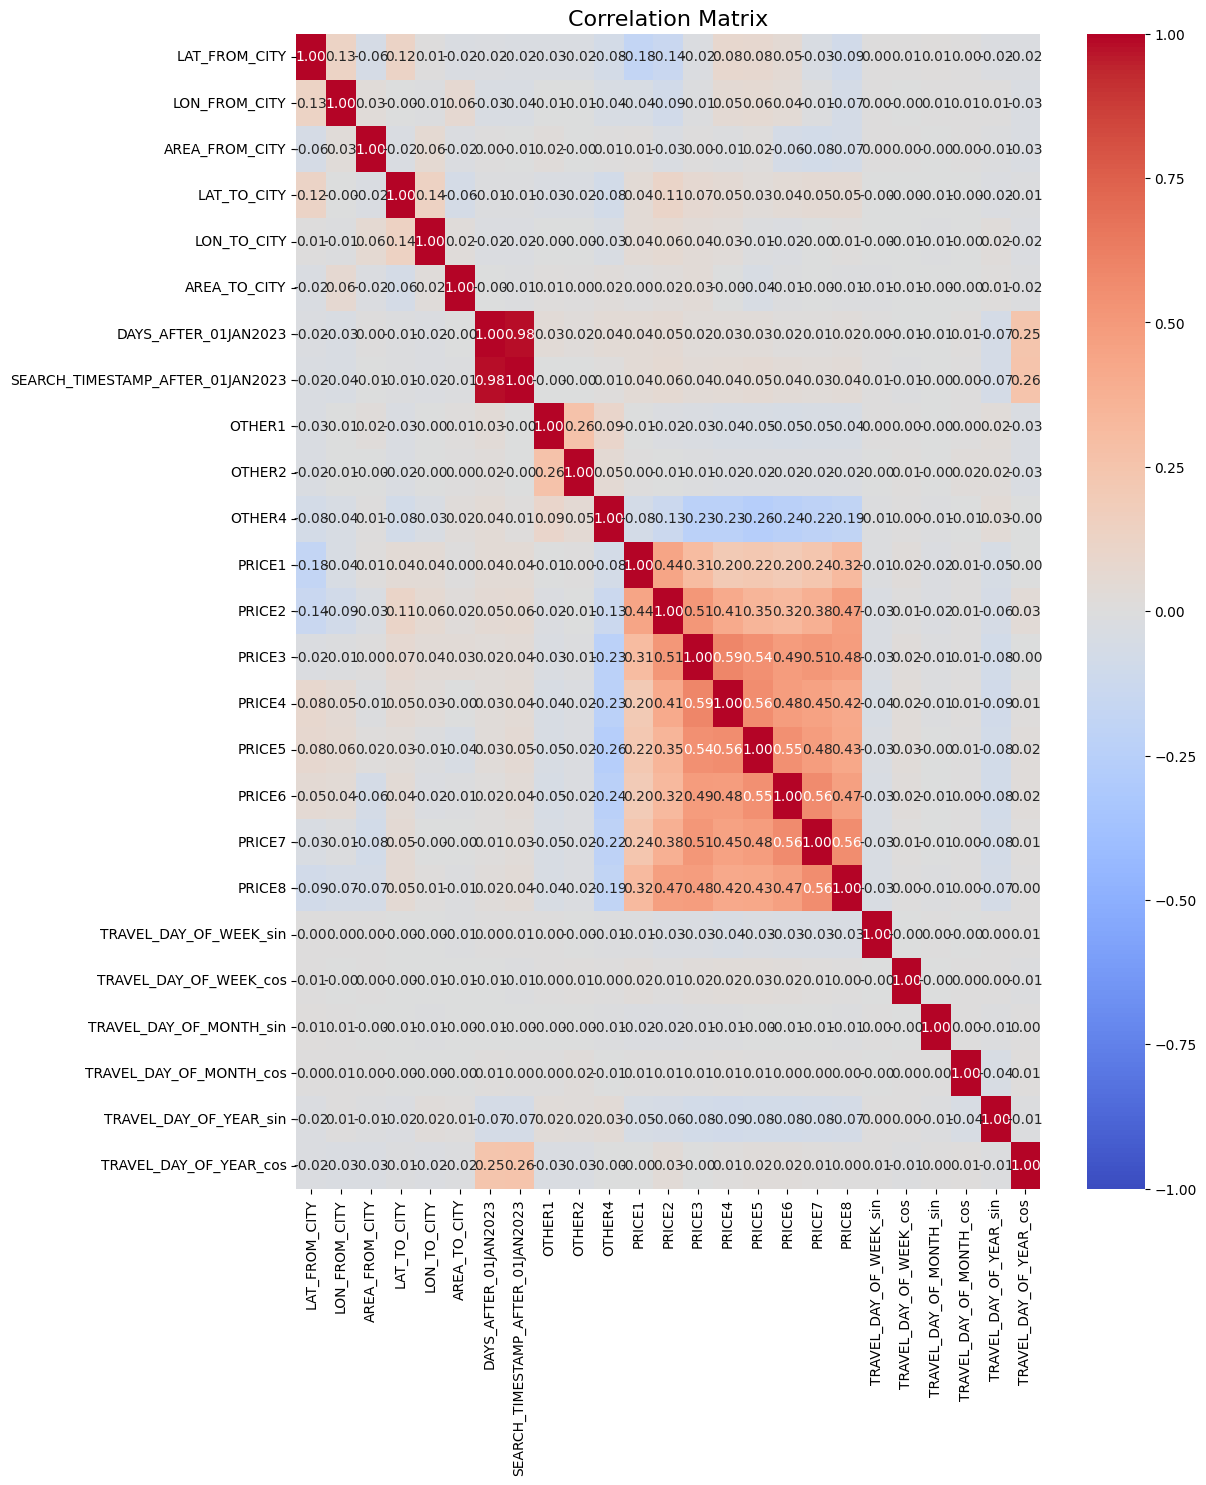

In [25]:
# Let's see the correlation between these useful columns
# Let's plot the correlation matrix
corr_matrix = train.corr()


# Plot the heatmap
plt.figure(figsize=(12, 15))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)

# Customize plot
plt.title("Correlation Matrix", fontsize=16)
plt.show()

In [26]:
# There are some high correlations
# Let's build a function to automatically remove the feature with highest VIF
def remove_high_vif_features_iteratively(df, threshold=5):
    """
    Iteratively removes features with the highest Variance Inflation Factor (VIF)
    until all remaining features have VIF below the specified threshold.

    """

    while True:
        # Compute VIF for all features
        vif_data = pd.DataFrame()
        vif_data["feature"] = df.columns
        vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

        # Find the feature with the highest VIF
        max_vif = vif_data["VIF"].max()
        if max_vif < threshold:  # Stop when all VIFs are below threshold
            break

        # Feature to remove
        feature_to_remove = vif_data.sort_values(by="VIF", ascending=False).iloc[0]["feature"]
        print(f"Removing '{feature_to_remove}' with VIF: {max_vif:.2f}")

        # Drop the feature
        df.drop(columns=[feature_to_remove], inplace=True)

    return df


In [27]:
train = remove_high_vif_features_iteratively(train)

Removing 'LAT_TO_CITY' with VIF: 147.66
Removing 'SEARCH_TIMESTAMP_AFTER_01JAN2023' with VIF: 50.67
Removing 'LAT_FROM_CITY' with VIF: 27.43
Removing 'LON_FROM_CITY' with VIF: 7.85
Removing 'LON_TO_CITY' with VIF: 5.33


In [28]:
train.columns

Index(['AREA_FROM_CITY', 'AREA_TO_CITY', 'DAYS_AFTER_01JAN2023', 'OTHER1',
       'OTHER2', 'OTHER4', 'PRICE1', 'PRICE2', 'PRICE3', 'PRICE4', 'PRICE5',
       'PRICE6', 'PRICE7', 'PRICE8', 'TRAVEL_DAY_OF_WEEK_sin',
       'TRAVEL_DAY_OF_WEEK_cos', 'TRAVEL_DAY_OF_MONTH_sin',
       'TRAVEL_DAY_OF_MONTH_cos', 'TRAVEL_DAY_OF_YEAR_sin',
       'TRAVEL_DAY_OF_YEAR_cos'],
      dtype='object')

In [29]:
#Subset val set so that it has also the same columns as train set
val = val[train.columns]

In [30]:
train.shape, val.shape

((2859384, 20), (317710, 20))

In [31]:
train.head()

,AREA_FROM_CITY,AREA_TO_CITY,DAYS_AFTER_01JAN2023,OTHER1,OTHER2,OTHER4,PRICE1,PRICE2,PRICE3,PRICE4,PRICE5,PRICE6,PRICE7,PRICE8,TRAVEL_DAY_OF_WEEK_sin,TRAVEL_DAY_OF_WEEK_cos,TRAVEL_DAY_OF_MONTH_sin,TRAVEL_DAY_OF_MONTH_cos,TRAVEL_DAY_OF_YEAR_sin,TRAVEL_DAY_OF_YEAR_cos
1080368,1.505246,0.545107,1.0,1.0,0.0,0.0,13091.0,9399.0,9419.0,21012.0,10679.0,-1.0,5417.0,10695.0,7.818315e-01,0.623490,0.394356,0.918958,0.034422,0.999407
1460718,1.138534,1.505246,-115.0,1.0,0.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-4.338837e-01,-0.900969,0.998717,-0.050649,-0.924291,-0.381689
2647583,1.510669,1.505246,-309.0,1.0,0.0,0.0,-1.0,8621.0,8512.0,8621.0,8512.0,8512.0,14146.0,8512.0,-7.818315e-01,0.623490,-0.848644,0.528964,0.831171,0.556017
2254046,1.945181,3.405019,-355.0,2.0,0.0,0.0,-1.0,-1.0,10087.0,16818.0,17268.0,13368.0,-1.0,-1.0,9.749279e-01,-0.222521,0.790776,-0.612106,0.188227,0.982126
2772768,3.730879,3.405019,-259.0,1.0,0.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-2.449294e-16,1.000000,-0.299363,-0.954139,0.963471,-0.267814


In [32]:
# Let's create a Pipeline to normalize all features
# 3️⃣ Create Pipeline with Normalization Only
scaling_pipeline = Pipeline([
    ("scaler", StandardScaler())  # Normalize features
])

# 4️⃣ Fit Pipeline on Training Data
scaling_pipeline.fit(train)

# Save Pipeline
os.makedirs(PIPELINE_ASSETS, exist_ok=True)
pipeline_name = os.path.join(PIPELINE_ASSETS,  'scaler_normalization.pkl')
# 6️⃣ Save Pipeline for Future Use
joblib.dump(scaling_pipeline, pipeline_name)

['/home/ar-in-u-301/Documents/MakeMyTripAssignment/pipeline_assets/scaler_normalization.pkl']

In [33]:
# Load the pipeline
scaling_pipeline = joblib.load(filename=pipeline_name)

In [ ]:
# COLUMN_NAMES = list( train.columns )
COLUMN_NAMES

['AREA_FROM_CITY',
 'AREA_TO_CITY',
 'DAYS_AFTER_01JAN2023',
 'OTHER1',
 'OTHER2',
 'OTHER4',
 'PRICE1',
 'PRICE2',
 'PRICE3',
 'PRICE4',
 'PRICE5',
 'PRICE6',
 'PRICE7',
 'PRICE8',
 'TRAVEL_DAY_OF_WEEK_sin',
 'TRAVEL_DAY_OF_WEEK_cos',
 'TRAVEL_DAY_OF_MONTH_sin',
 'TRAVEL_DAY_OF_MONTH_cos',
 'TRAVEL_DAY_OF_YEAR_sin',
 'TRAVEL_DAY_OF_YEAR_cos']

In [ ]:


train =  pd.DataFrame( 
    scaling_pipeline.transform( train ),
    columns=COLUMN_NAMES
)

val = pd.DataFrame(
    scaling_pipeline.transform( val),
    columns=COLUMN_NAMES
)


In [36]:
# Let's save these dataframes for model fitting
train['ACTIVITY_TYPE'] = y_train
val['ACTIVITY_TYPE'] = y_val

In [37]:
# Let's save these 2 dataframes
train.to_feather(os.path.join(PROJECT_ROOT, "data", "train_processed_without_city_pair.feather"))
val.to_feather(os.path.join(PROJECT_ROOT, "data", "val_processed_without_city_pair.feather"))

In [38]:
# Now let's add the city pair information back to the dataframes and save those too
train['FROM_TO_CITY'] = city_pair_train
val['FROM_TO_CITY'] = city_pair_val

In [ ]:
COLUMN_NAMES.append('ACTIVITY_TYPE')
COLUMN_NAMES

['AREA_FROM_CITY',
 'AREA_TO_CITY',
 'DAYS_AFTER_01JAN2023',
 'OTHER1',
 'OTHER2',
 'OTHER4',
 'PRICE1',
 'PRICE2',
 'PRICE3',
 'PRICE4',
 'PRICE5',
 'PRICE6',
 'PRICE7',
 'PRICE8',
 'TRAVEL_DAY_OF_WEEK_sin',
 'TRAVEL_DAY_OF_WEEK_cos',
 'TRAVEL_DAY_OF_MONTH_sin',
 'TRAVEL_DAY_OF_MONTH_cos',
 'TRAVEL_DAY_OF_YEAR_sin',
 'TRAVEL_DAY_OF_YEAR_cos',
 'ACTIVITY_TYPE']

In [44]:
COLUMN_NAMES = (['FROM_TO_CITY'] + COLUMN_NAMES)
COLUMN_NAMES

['FROM_TO_CITY',
 'AREA_FROM_CITY',
 'AREA_TO_CITY',
 'DAYS_AFTER_01JAN2023',
 'OTHER1',
 'OTHER2',
 'OTHER4',
 'PRICE1',
 'PRICE2',
 'PRICE3',
 'PRICE4',
 'PRICE5',
 'PRICE6',
 'PRICE7',
 'PRICE8',
 'TRAVEL_DAY_OF_WEEK_sin',
 'TRAVEL_DAY_OF_WEEK_cos',
 'TRAVEL_DAY_OF_MONTH_sin',
 'TRAVEL_DAY_OF_MONTH_cos',
 'TRAVEL_DAY_OF_YEAR_sin',
 'TRAVEL_DAY_OF_YEAR_cos',
 'ACTIVITY_TYPE']

In [45]:
#Reorder Columns
train = train[COLUMN_NAMES]
val = val[COLUMN_NAMES]

In [46]:
# Save as Feather
train.to_feather(os.path.join(PROJECT_ROOT, "data", "train_processed_with_city_pair.feather"))
val.to_feather(os.path.join(PROJECT_ROOT, "data", "val_processed_with_city_pair.feather"))